In [1]:
import os
import random
import sys
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
from casadi import dot, Opti, vertsplit, vertcat

from core.generator import (
    gen_ref_step,
    gen_step,
    gen_u_daily_sine,
    gen_u_naive_control,
)
from core.lettuce_model import _lettuce_growth_model, lettuce_growth_model
from core.plot import plot_response, plot_states
from core.simulate import simulate

random.seed(40)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Setup Google Colab Environment
if "google.colab" in sys.modules:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    os.chdir(userdata.get("project_path"))
    !git pull
    !git checkout dev
    !git pull
    %pip install -r requirements-dev.txt
    !pre-commit install --hook-type pre-push

In [4]:
# Commit changes
if "google.colab" in sys.modules:
    !git add -A
    name = userdata.get("github_name")
    email = userdata.get("github_email")
    !git -c user.name="$name" user.email="$email" commit -m "FIX: Githu"

In [5]:
# Push changes to GitHub
if "google.colab" in sys.modules:
    token = userdata.get("github_token")
    !git push https://$token@github.com/MarekWadinger/dynamic_opt_growth_model.git

In [6]:
x0 = [0.72, 2.7]  # Vanhenten 1994
u_min = [10, 0, 400]
u_max = [25, 100, 800]

In [7]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0
)

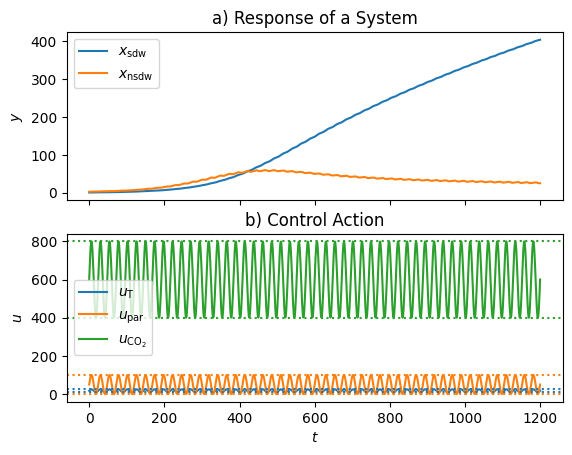

In [8]:
plot_response(t_out, y_out, u_out, u_min=u_min, u_max=u_max)
plt.show()

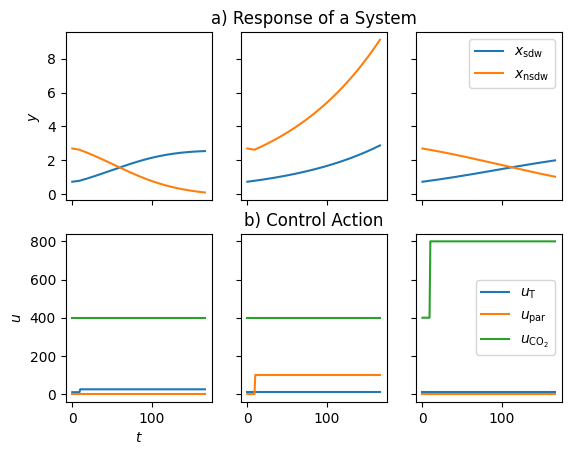

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 2].legend()

plt.show()

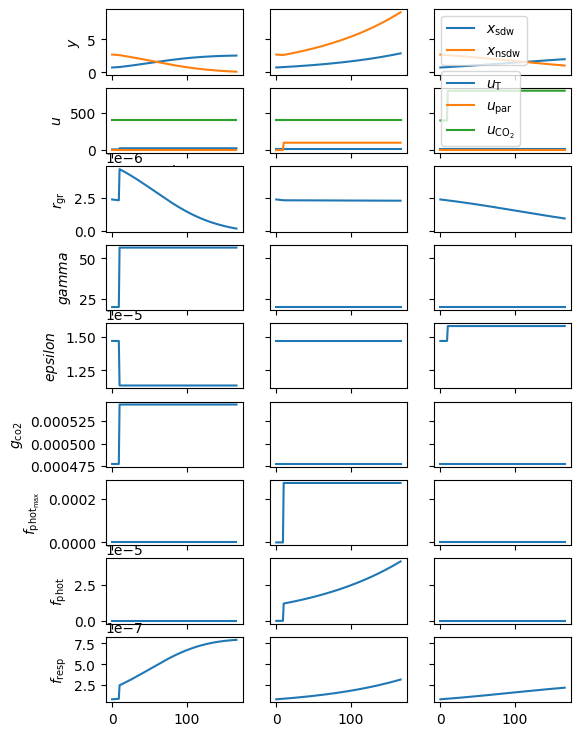

In [10]:
fig, axs = plt.subplots(
    nrows=2 + 7,
    ncols=len(u_max),
    figsize=(6, 9),
    sharex=True,
    sharey="row",
)

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
    )
    plot_response(t_out, y_out, u_out, axs_=axs[:, u_idx])

    # Replay simulation to get states
    xs = []
    for x, u in zip(y_out, u_out):
        _, _, x_ = _lettuce_growth_model(0, tuple(x), tuple(u))
        xs.append(x_)
    i = 0
    df = pd.DataFrame(xs)

    # Plot states
    plot_states(df, axs[2:, u_idx], u_idx == 0)

axs[0, 0].set_ylabel("$y$")
axs[0, 2].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 2].legend()

plt.show()

In [11]:
u = partial(gen_u_naive_control, u_min=u_min, u_max=u_max)
ref = partial(gen_ref_step, x_step=[50, 5])

t_out, y_out, u_out, y_ref = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0, ref_gen=ref
)

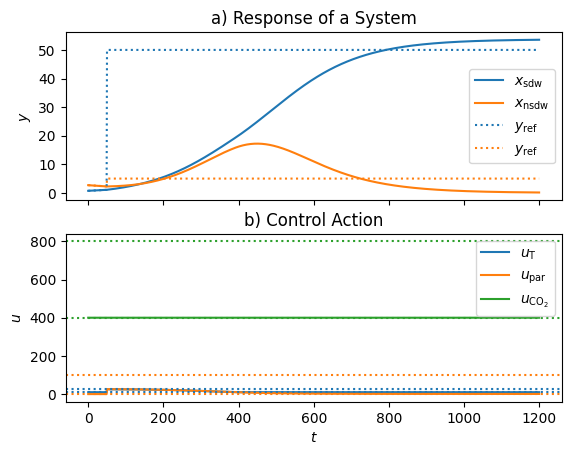

In [12]:
plot_response(t_out, y_out, u_out, y_ref=y_ref, u_min=u_min, u_max=u_max)
plt.show()

In [13]:
opti = Opti()  # Optimization problem

N = 50  # number of control intervals
x_ref = [50, 5]  # reference state
# ---- decision variables ---------
X = opti.variable(2, N + 1)  # state trajectory
x_sdw = X[0, :]
x_nsdw = X[1, :]
U = opti.variable(3, N)  # control trajectory (u_T, u_par, u_co2)
# T = opti.variable()

# ---- objective          ---------
opti.minimize(dot(X - x_ref, X - x_ref))  # reference tracking

# ---- dynamic constraints --------
dt = 86400  # T / N


def f(x, u):
    return vertcat(*lettuce_growth_model(0, vertsplit(x), vertsplit(u)))


for k in range(N):
    k1 = f(X[:, k], U[:, k])
    k2 = f(X[:, k] + dt / 2 * k1, U[:, k])
    k3 = f(X[:, k] + dt / 2 * k2, U[:, k])
    k4 = f(X[:, k] + dt * k3, U[:, k])
    x_next = X[:, k] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    opti.subject_to(X[0, k + 1] == x_next[0])
    opti.subject_to(X[1, k + 1] == x_next[1])

# ---- path constraints -----------
for i in range(U.shape[0]):
    opti.subject_to(U[i, :] >= u_min[i])
    opti.subject_to(U[i, :] <= u_max[i])
for i in range(X.shape[0]):
    opti.subject_to(X[i, :] >= 0.01)

# ---- boundary conditions and initial values for solver --------
for i in range(X.shape[0]):
    opti.subject_to(X[i, 0] == x0[i])
    opti.subject_to(X[0, -1] == 50)
    opti.set_initial(X[i, :], x0[i])
    # opti.set_initial(T, 1)

# ---- misc. constraints  ----------
# opti.subject_to(T >= 0)  # Time must be positive

# ---- solve NLP              ------
opti.solver("ipopt")  # set numerical backend
sol = opti.solve()  # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      604
Number of nonzeros in inequality constraint Jacobian.:      402
Number of nonzeros in Lagrangian Hessian.............:      752

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality c

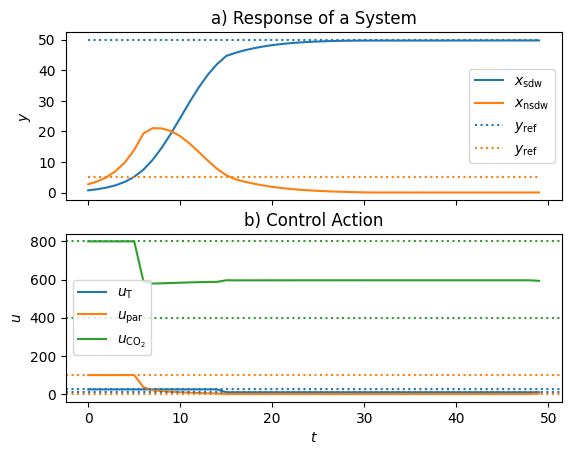

In [14]:
plot_response(
    range(N),
    sol.value(X).T[:-1],
    sol.value(U).T,
    y_ref=[x_ref] * N,
    u_min=u_min,
    u_max=u_max,
)
plt.show()

In [15]:
t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=sol.value(U).T, sim_time=50, t_s=86400, x0=x0
)

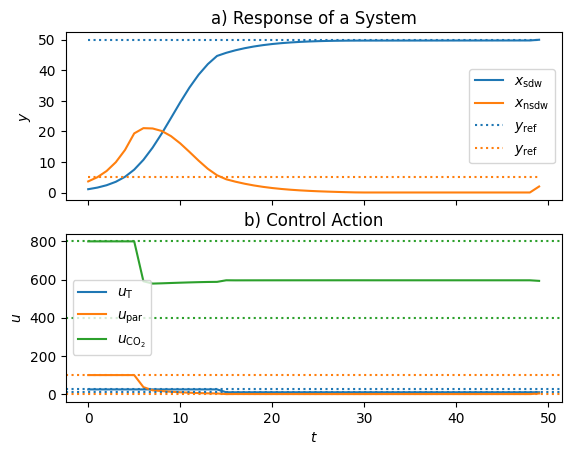

In [16]:
plot_response(
    t_out,
    y_out,
    u_out,
    y_ref=[x_ref] * N,
    u_min=u_min,
    u_max=u_max,
)
plt.show()